In [401]:
import torch
import matplotlib.pyplot as plt

from torch import nn

## Simple Linear Regression

### 1. Creating Dataset

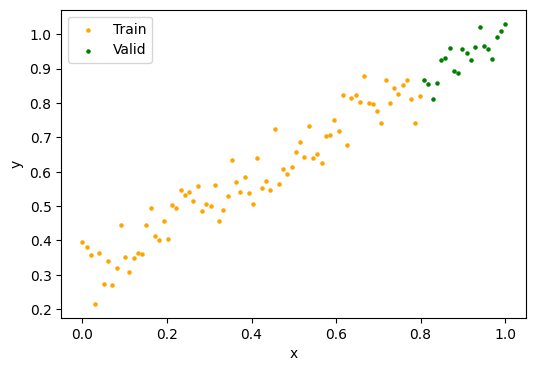

In [402]:
torch.manual_seed(42)
n_points = 100
noise = torch.randn(n_points, 1) * 0.05
weight, bias = 0.7, 0.3

X = torch.linspace(0, 1, n_points).unsqueeze(dim=1)
y = weight * X + bias + noise

train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:], y[train_size:]

plt.figure(figsize=(6, 4))
plt.scatter(X_train, y_train, c="orange", s=5, label="Train")
plt.scatter(X_valid, y_valid, c="green", s=5, label="Valid")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

### 2. Creating Model

In [403]:
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.weight * x + self.bias

In [404]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

In [405]:
# Model parameters.
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [406]:
# Model named parameters.
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [407]:
# Make predictions
with torch.inference_mode():  # Turn off gradient tracking
    y_preds = model_0(X_valid)

y_preds.squeeze()[:5]

tensor([0.4009, 0.4043, 0.4077, 0.4111, 0.4145])

In [408]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.min_valid_loss = float("inf")
        self.counter = 0

    def should_stop(self, valid_loss):
        if valid_loss < self.min_valid_loss:
            self.min_valid_loss = valid_loss
            self.counter = 0
        elif valid_loss - self.min_valid_loss > self.min_delta:
            self.counter += 1
            if self.counter == self.patience:
                return True
        return False

### 3. Training Loop

In [409]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)
early_stopping = EarlyStopping(patience=5, min_delta=1e-5)

In [410]:
# Training loop.
n_epochs = 100
epoch_values = []
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    epoch_values.append(epoch)
    # 0. Set the model to the training mode.
    model_0.train()
    # 1. Forward pass.
    y_train_pred = model_0(X_train)
    # 2. Calculate the loss.
    loss = loss_fn(y_train_pred, y_train)
    train_losses.append(loss.item())
    # 3. Zero gradient step -> reset gradients.
    optimizer.zero_grad()
    # 4. Perform backpropagation with respect to the model parameters -> calculate gradients.
    loss.backward()
    # 5. Optimizer step -> apply gradients.
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_valid_pred = model_0(X_valid)
        valid_loss = loss_fn(y_valid_pred, y_valid)

    valid_losses.append(valid_loss.item())
    if early_stopping.should_stop(valid_loss.item()):
        print("Early Stopping")
        break

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d} | Loss: {loss:.5f} | Valid Loss: {valid_loss:.5f}")

Epoch: 000 | Loss: 0.31948 | Valid Loss: 0.36519
Epoch: 010 | Loss: 0.05368 | Valid Loss: 0.07943
Epoch: 020 | Loss: 0.04734 | Valid Loss: 0.04294
Epoch: 030 | Loss: 0.04606 | Valid Loss: 0.04454
Epoch: 040 | Loss: 0.04479 | Valid Loss: 0.02962
Epoch: 050 | Loss: 0.04433 | Valid Loss: 0.02979
Early Stopping


In [411]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6863])), ('bias', tensor([0.3013]))])

In [412]:
with torch.inference_mode():
    preds = model_0(X_valid)

preds.squeeze()[:5]

tensor([0.8559, 0.8628, 0.8698, 0.8767, 0.8836])

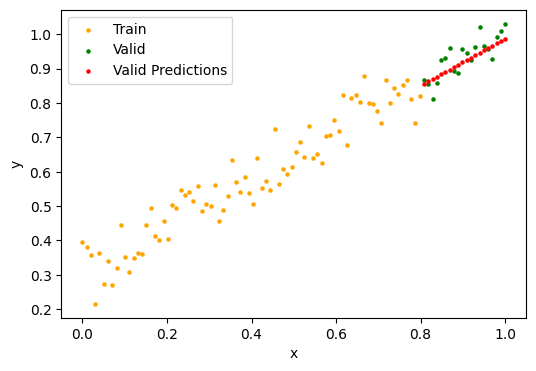

In [413]:
plt.figure(figsize=(6, 4))
plt.scatter(X_train, y_train, c="orange", s=5, label="Train")
plt.scatter(X_valid, y_valid, c="green", s=5, label="Valid")
plt.scatter(X_valid, preds, c="red", s=5, label="Valid Predictions")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

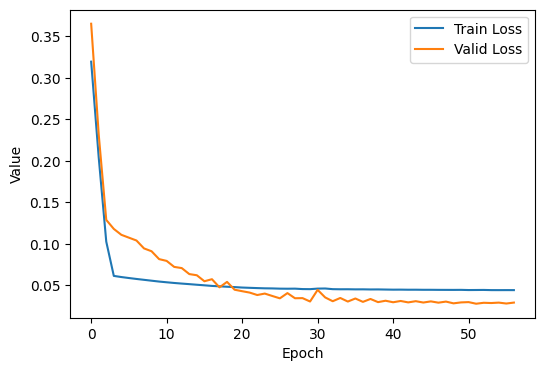

In [414]:
plt.figure(figsize=(6, 4))
plt.plot(epoch_values, train_losses, label="Train Loss")
plt.plot(epoch_values, valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

### 4. Model Saving

In [415]:
print("Model's state dict:\n")
for param_tensor in model_0.state_dict():
    print(param_tensor.ljust(10), model_0.state_dict()[param_tensor].size())

Model's state dict:

weight     torch.Size([1])
bias       torch.Size([1])


In [416]:
torch.save(model_0.state_dict(), "linear_reg_params.pt")

In [417]:
model_1 = LinearRegressionModel()
model_1.load_state_dict(torch.load("linear_reg_params.pt"))
model_1.state_dict()

OrderedDict([('weight', tensor([0.6863])), ('bias', tensor([0.3013]))])

In [418]:
model_scripted = torch.jit.script(model_0)
model_scripted.save("linear_reg_model.pt")  # type: ignore

## Three Dimensional Linear Regression

### 1. Creating Linear Data

In [419]:
torch.manual_seed(42)

weight = torch.tensor((0.5, 0.5))
bias = torch.tensor(1.0)
n_points = 1000

x = torch.linspace(0, 1, n_points).unsqueeze(dim=1)
z = torch.linspace(1, 2, n_points).unsqueeze(dim=1)

X = torch.hstack((x, z)) + torch.randn(n_points, 2) * 0.1
y = weight @ X.T + bias

In [420]:
X[:5]

tensor([[ 0.1927,  1.1487],
        [ 0.0911,  0.7904],
        [ 0.0698,  0.8785],
        [-0.0013,  0.8425],
        [-0.0712,  1.1689]])

In [421]:
y[:5]

tensor([1.6707, 1.4408, 1.4742, 1.4206, 1.5488])

In [422]:
valid_ratio = 0.2
ids = torch.randperm(n_points)
valid_size = int(n_points * valid_ratio)

X_train, y_train = X[ids[:-valid_size]], y[ids[:-valid_size]]
X_valid, y_valid = X[ids[-valid_size:]], y[ids[-valid_size:]]

len(y_train), len(y_valid)

(800, 200)

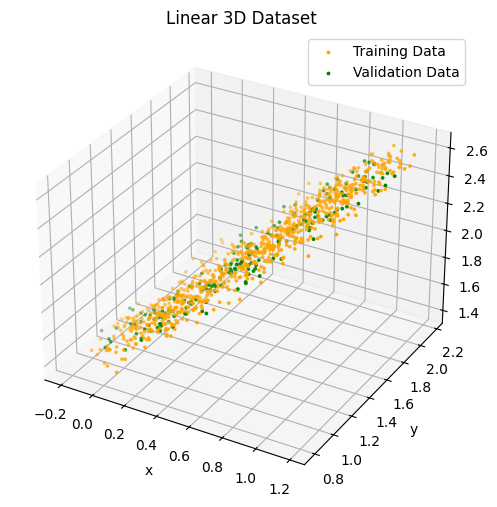

In [423]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, s=3, c="orange", label="Training Data")
ax.scatter(X_valid[:, 0], X_valid[:, 1], y_valid, s=3, c="green", label="Validation Data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()
plt.title("Linear 3D Dataset")
plt.show()

### 2. Model Creation

In [424]:
class LinearRegressionModel3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.units = nn.Linear(in_features=2, out_features=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.units(x))

In [425]:
torch.manual_seed(42)

model_1 = LinearRegressionModel3D()
model_1.state_dict()

OrderedDict([('units.weight', tensor([[0.5406, 0.5869]])),
             ('units.bias', tensor([-0.1657]))])

### 3. Training Loop

In [426]:
import math

batch_size = 32
n_batches = math.ceil(n_points / batch_size)

loss_fn = nn.L1Loss()  # MAE Loss.
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.002)

In [427]:
n_epochs = 300
epoch_values = []
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    epoch_values.append(epoch)
    model_1.train()
    loss = 0

    for batch in range(n_batches):
        rand_ids = torch.randint(0, len(X_train) - 1, (batch_size,))
        X_true, y_true = X_train[rand_ids], y_train[rand_ids]
        y_pred = model_1(X_true).squeeze()

        train_loss = loss_fn(y_pred, y_true)
        loss += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    loss /= n_batches
    train_losses.append(loss)
    model_1.eval()

    with torch.inference_mode():
        y_valid_pred = model_1(X_valid).squeeze()
        valid_loss = loss_fn(y_valid_pred, y_valid)

    valid_losses.append(valid_loss.item())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d} | Loss: {loss:.5f} | Valid Loss: {valid_loss:.5f}")

Epoch: 000 | Loss: 0.91102 | Valid Loss: 0.79521
Epoch: 010 | Loss: 0.15577 | Valid Loss: 0.14852
Epoch: 020 | Loss: 0.12831 | Valid Loss: 0.11805
Epoch: 030 | Loss: 0.09460 | Valid Loss: 0.08946
Epoch: 040 | Loss: 0.06963 | Valid Loss: 0.06359
Epoch: 050 | Loss: 0.04805 | Valid Loss: 0.04601
Epoch: 060 | Loss: 0.04015 | Valid Loss: 0.03856
Epoch: 070 | Loss: 0.03703 | Valid Loss: 0.03553
Epoch: 080 | Loss: 0.03347 | Valid Loss: 0.03232
Epoch: 090 | Loss: 0.03066 | Valid Loss: 0.03015
Epoch: 100 | Loss: 0.02914 | Valid Loss: 0.02756
Epoch: 110 | Loss: 0.02740 | Valid Loss: 0.02508
Epoch: 120 | Loss: 0.02341 | Valid Loss: 0.02270
Epoch: 130 | Loss: 0.02073 | Valid Loss: 0.02060
Epoch: 140 | Loss: 0.01892 | Valid Loss: 0.01803
Epoch: 150 | Loss: 0.01633 | Valid Loss: 0.01560
Epoch: 160 | Loss: 0.01406 | Valid Loss: 0.01317
Epoch: 170 | Loss: 0.01119 | Valid Loss: 0.01080
Epoch: 180 | Loss: 0.00901 | Valid Loss: 0.00863
Epoch: 190 | Loss: 0.00661 | Valid Loss: 0.00613
Epoch: 200 | Loss: 0

In [428]:
model_1.state_dict()

OrderedDict([('units.weight', tensor([[0.4952, 0.5079]])),
             ('units.bias', tensor([0.9946]))])